In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import matplotlib.patches as patches
import tensorflow as tf
import PIL
import random
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imageio
from skimage import transform,io
from distutils.dir_util import copy_tree
import shutil
import os

In [58]:
import imageio

## 1- Lets build our Augmentated dataset in augdata

In [48]:
#-----------------Init-------------
shutil.rmtree("./data/augdata/images")
shutil.copytree("./data/photodata/", "./data/augdata/images/")
print("Folder Copied")

Folder Copied


In [49]:
categories=["MIT","AM","X","STAN","CS","HARV"]
folder="./data/augdata/images"
size=150
data=[]
aug=1
#vertical_flip=True
#horizontal_flip=True,
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        brightness_range=[0.2,1.0])
for cat in categories:
    data=[]
    pathdata=os.path.join(folder,cat)
    class_num=categories.index(cat)
    for img in os.listdir(pathdata):        
        imgarray = imageio.imread(os.path.join(pathdata,img), pilmode='RGB')
        imgresized = transform.resize(imgarray, (size,size), mode='symmetric')
        #plt.imshow(imgresized)
        #plt.show()
        data.append([np.array(imgresized),class_num])
    #Augmentate Data for each cat
    random.shuffle(data)
    X=[]
    y=[]
    for features, label in data:
        X.append(features)
        y.append(label)
    X=np.array(X).reshape(-1,size,size,3)
    y=np.array(y)
    #fit
    datagen.fit(X)
    batches=datagen.flow(X, y,save_to_dir=pathdata,
                  save_prefix=cat, save_format='jpg')
    for i in range(aug):
        next(batches)

## 2- Lets build our Training and Testing Set

In [51]:
categories=["MIT","AM","X","STAN","CS","HARV"]
#if you want augmented dataset uncomment next line
folder="./data/augdata/images"
#folder=".\photodata"
size=150
data=[]
for cat in categories:
    pathdata=os.path.join(folder,cat)
    class_num=categories.index(cat)
    for img in os.listdir(pathdata):
        imgarray = imageio.imread(os.path.join(pathdata,img), pilmode='RGB')
        imgresized = transform.resize(imgarray, (size,size), mode='symmetric')
        #plt.imshow(imgresized)
        #plt.show()
        data.append([imgresized,class_num])
import random
random.shuffle(data)


X=[]
y=[]
for features, label in data:
    X.append(features)
    y.append(label)
    
X=np.array(X).reshape(-1,size,size,3)
y=pd.DataFrame(y)
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder()
#y=enc.fit_transform(y.reshape(-1,1)).toarray()
y=pd.get_dummies(y.astype(str),prefix=['label'])

print("The dataset size is")
print(X.shape,y.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42,shuffle=True)
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42,shuffle=True)
print("The trainingset size is")
print(X_train.shape,y_train.shape)
print("The testingset size is")
print(X_test.shape,y_test.shape)
print("The validationset size is")
print(X_valid.shape,y_valid.shape)

The dataset size is
(204, 150, 150, 3) (204, 6)
The trainingset size is
(142, 150, 150, 3) (142, 6)
The testingset size is
(31, 150, 150, 3) (31, 6)
The validationset size is
(31, 150, 150, 3) (31, 6)


## 3- Let's Build THE CNN

In [52]:
droprate=0.2
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(size,size,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(droprate),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(droprate),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dropout(droprate),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(6,activation="softmax")
])
#opt=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

## 4- Training

In [ ]:
from datetime import datetime
logdir = "logs\scalars\ " + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    X_train, # input
    y_train, # output
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=100,
    validation_data=(X_valid,y_valid),
    callbacks=[tensorboard_callback],
)

## 5- Scores

In [54]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2769792377948761
Test accuracy: 0.9677419066429138


## 6- Save/Load Model

In [53]:
#model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#print("model saved")
model = tf.keras.models.load_model('./data/my_model.h5')
print("model loaded")


model loaded


## 7- Test on images

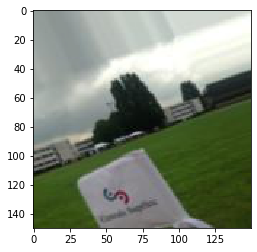

[[7.66934463e-05 2.06520800e-02 1.08357242e-04 7.34238625e-02
  9.05618668e-01 1.20379766e-04]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.90561867


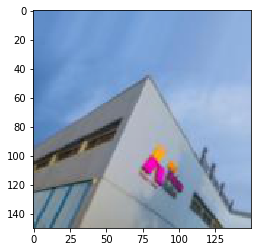

[[2.5058704e-04 5.9413735e-02 9.3935835e-01 1.3220483e-04 8.1801118e-04
  2.7078657e-05]]
X !!!!!!!!!!!
The winner got a score of 0.93935835


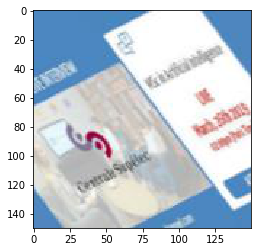

[[3.0713476e-04 1.1228304e-02 1.9106683e-03 6.0627726e-03 9.8022479e-01
  2.6626547e-04]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9802248


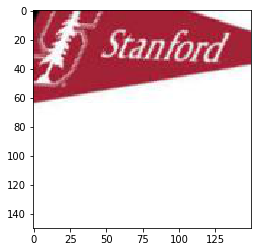

[[0.4424865  0.44279656 0.01886916 0.06072104 0.03003369 0.00509314]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.44279656


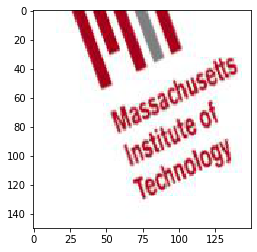

[[9.9714261e-01 3.8012331e-06 1.4232660e-06 2.2302081e-03 6.1848632e-04
  3.4427785e-06]]
MIT !!!!!!!!!!
The winner got a score of 0.9971426


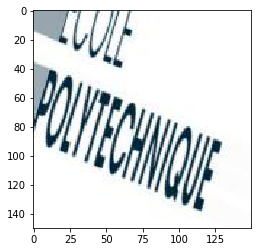

[[6.7931450e-07 9.5325338e-11 9.9999928e-01 1.3131978e-09 2.7709593e-10
  4.6598949e-08]]
X !!!!!!!!!!!
The winner got a score of 0.9999993


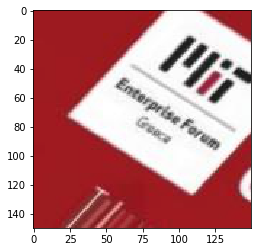

[[9.9707663e-01 8.2655770e-06 1.8495308e-06 1.3543296e-04 6.5745291e-05
  2.7120288e-03]]
MIT !!!!!!!!!!
The winner got a score of 0.99707663


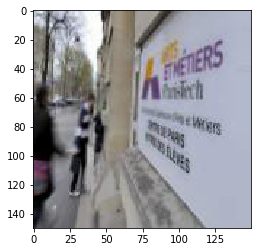

[[4.0873201e-04 9.9936777e-01 1.1291169e-04 3.9859988e-05 2.0765847e-05
  4.9888222e-05]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9993678


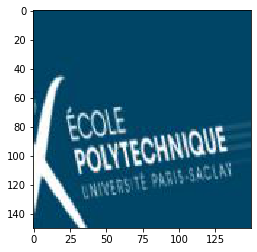

[[4.5893438e-26 3.0392427e-34 1.0000000e+00 4.7006774e-30 7.5345221e-33
  7.2070102e-33]]
X !!!!!!!!!!!
The winner got a score of 1.0


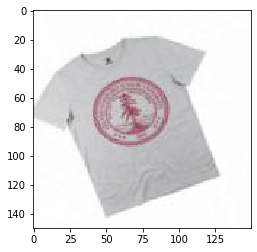

[[0.00570227 0.00219258 0.00566405 0.95235157 0.03189926 0.00219015]]
STANFORD!!!!!!!!
The winner got a score of 0.95235157


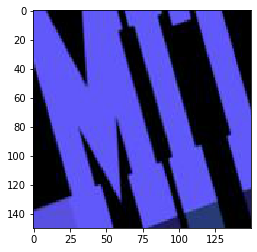

[[1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  8.195144e-31]]
MIT !!!!!!!!!!
The winner got a score of 1.0


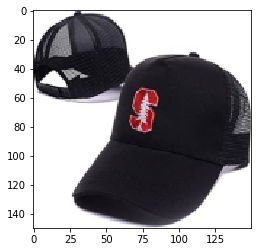

[[3.4684038e-07 2.2964682e-11 7.4583326e-11 9.9999905e-01 5.4194697e-07
  9.5613855e-09]]
STANFORD!!!!!!!!
The winner got a score of 0.99999905


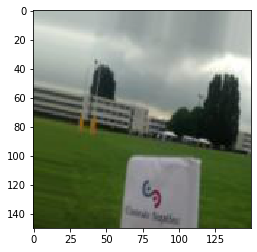

[[7.7035014e-07 1.2992750e-04 8.4710558e-07 4.5865709e-05 9.9981982e-01
  2.8369977e-06]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9998198


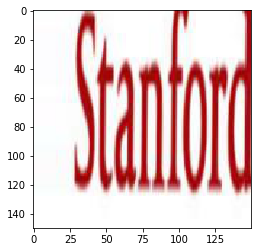

[[1.5310105e-19 1.9436147e-25 6.8730781e-23 1.0000000e+00 4.7330038e-18
  1.9211527e-19]]
STANFORD!!!!!!!!
The winner got a score of 1.0


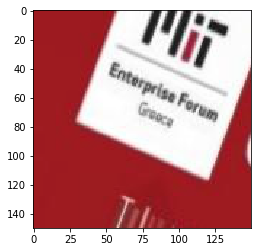

[[9.9947780e-01 6.7217265e-06 1.5549354e-06 3.3506192e-05 1.1376395e-05
  4.6922980e-04]]
MIT !!!!!!!!!!
The winner got a score of 0.9994778


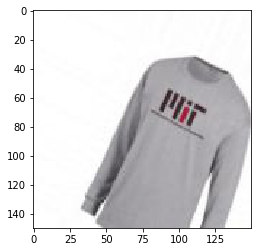

[[0.00277146 0.01232718 0.00266343 0.0041221  0.97629106 0.00182474]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.97629106


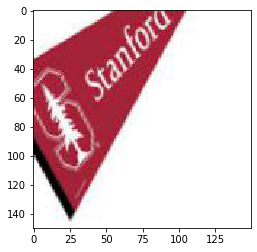

[[9.9993336e-01 2.0837772e-08 6.1957484e-09 6.5634536e-05 8.3175841e-08
  8.4900626e-07]]
MIT !!!!!!!!!!
The winner got a score of 0.99993336


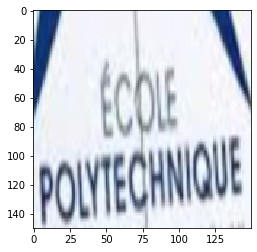

[[3.13201099e-06 2.35013626e-08 9.99996662e-01 1.02887306e-07
  7.44945439e-08 4.26499760e-08]]
X !!!!!!!!!!!
The winner got a score of 0.99999666


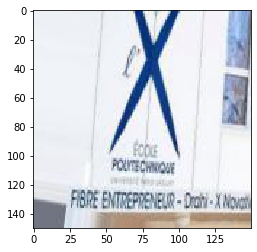

[[7.3379410e-13 5.3397579e-19 1.0000000e+00 2.5951573e-16 3.2155037e-15
  1.3647845e-16]]
X !!!!!!!!!!!
The winner got a score of 1.0


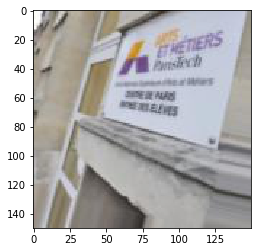

[[1.0884939e-04 9.9987710e-01 7.9231122e-06 1.8621056e-06 2.0987391e-06
  2.1092353e-06]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9998771


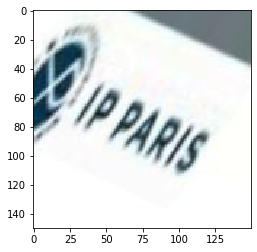

[[1.5083131e-04 2.2167385e-06 9.9981731e-01 1.2334520e-05 8.8084616e-06
  8.5597749e-06]]
X !!!!!!!!!!!
The winner got a score of 0.9998173


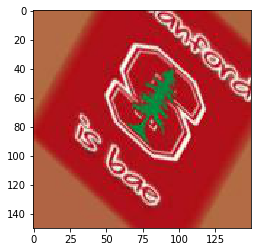

[[0. 0. 0. 1. 0. 0.]]
STANFORD!!!!!!!!
The winner got a score of 1.0


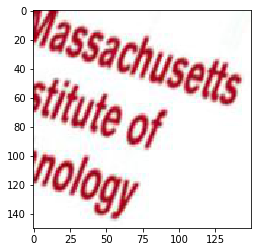

[[3.4238182e-02 8.2771067e-04 2.2056217e-04 1.1187306e-02 5.0791362e-03
  9.4844711e-01]]
HARVARD ITCH!!!!!!!!
The winner got a score of 0.9484471


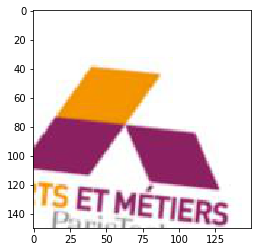

[[0. 1. 0. 0. 0. 0.]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


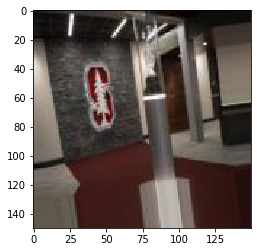

[[0.01875607 0.00341185 0.00278605 0.7290822  0.23404396 0.01191984]]
STANFORD!!!!!!!!
The winner got a score of 0.7290822


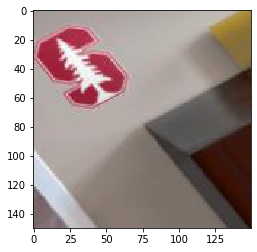

[[0.04294228 0.0022932  0.00188372 0.9158928  0.0339279  0.0030601 ]]
STANFORD!!!!!!!!
The winner got a score of 0.9158928


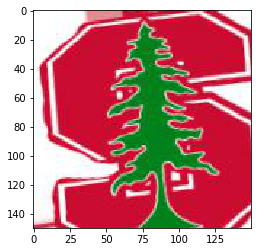

[[0. 0. 0. 1. 0. 0.]]
STANFORD!!!!!!!!
The winner got a score of 1.0


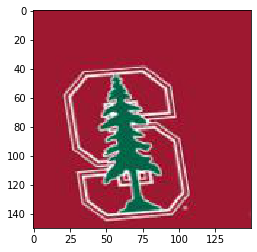

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.4568773e-38
  0.0000000e+00]]
STANFORD!!!!!!!!
The winner got a score of 1.0


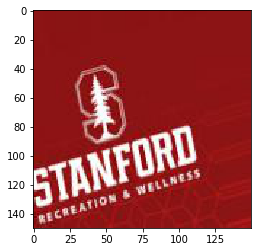

[[7.8802911e-16 4.5111777e-21 8.6681089e-19 1.0000000e+00 1.2928288e-14
  1.8013334e-16]]
STANFORD!!!!!!!!
The winner got a score of 1.0


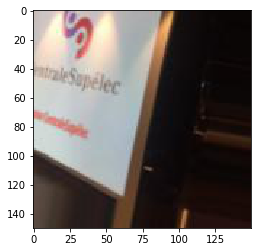

[[3.7276568e-05 6.7832028e-03 1.8076260e-05 2.9201637e-04 9.9285758e-01
  1.1841898e-05]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9928576


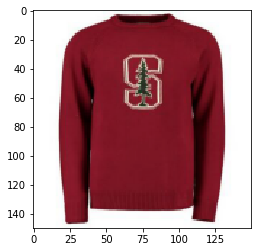

[[1.7772381e-05 2.8339633e-07 1.2755128e-06 9.9994695e-01 2.6412572e-05
  7.2684466e-06]]
STANFORD!!!!!!!!
The winner got a score of 0.99994695


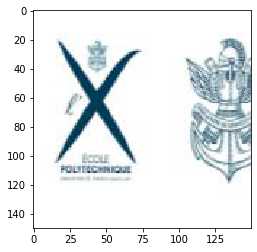

[[2.1457667e-14 2.8921664e-19 1.0000000e+00 1.1274741e-15 7.3191637e-18
  8.9701329e-16]]
X !!!!!!!!!!!
The winner got a score of 1.0


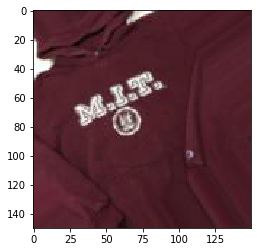

[[9.9964428e-01 2.7575314e-05 6.2219583e-06 2.1815710e-04 7.7123361e-05
  2.6661384e-05]]
MIT !!!!!!!!!!
The winner got a score of 0.9996443


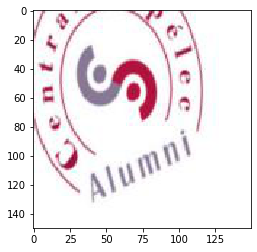

[[3.8388155e-08 4.0493211e-07 6.3396143e-11 6.2789223e-07 9.9999893e-01
  8.8502830e-11]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9999989


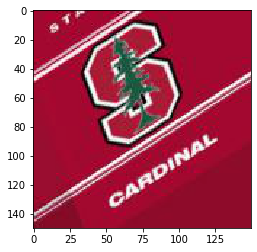

[[9.6682658e-14 5.8718744e-19 1.6290709e-16 1.0000000e+00 4.0850830e-13
  8.1654762e-14]]
STANFORD!!!!!!!!
The winner got a score of 1.0


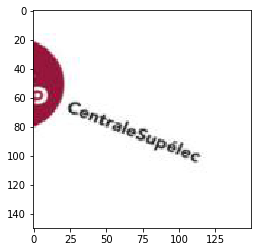

[[1.1758521e-05 1.3210273e-03 8.3345869e-05 1.5514508e-04 9.8688203e-01
  1.1546642e-02]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.98688203


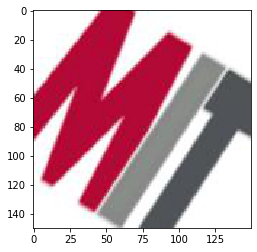

[[9.9999082e-01 5.2128386e-09 1.5589927e-09 8.8008455e-06 2.8137225e-07
  1.2359941e-07]]
MIT !!!!!!!!!!
The winner got a score of 0.9999908


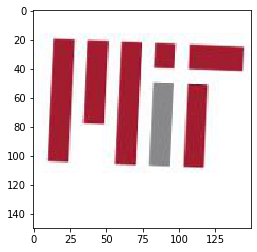

[[9.9214327e-01 3.3643999e-04 3.5341560e-05 6.8020233e-04 5.3352788e-03
  1.4694051e-03]]
MIT !!!!!!!!!!
The winner got a score of 0.9921433


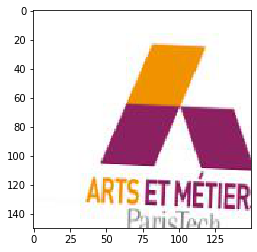

[[6.4584689e-27 1.0000000e+00 9.4839727e-30 2.7510677e-31 3.1393052e-29
  4.5643179e-29]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


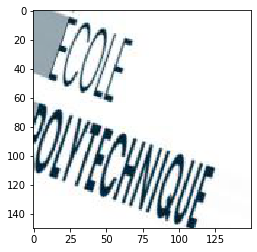

[[1.6865030e-08 2.5351774e-11 1.0000000e+00 2.9690619e-10 2.3448851e-10
  3.8466363e-10]]
X !!!!!!!!!!!
The winner got a score of 1.0


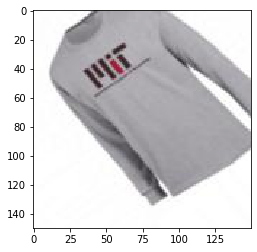

[[9.8792541e-01 4.0050316e-05 1.0214379e-04 6.9445255e-04 1.1216782e-02
  2.1152506e-05]]
MIT !!!!!!!!!!
The winner got a score of 0.9879254


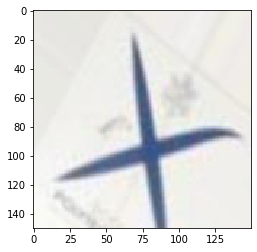

[[3.3017045e-03 1.5927196e-04 9.9460393e-01 1.3016872e-03 3.7951372e-04
  2.5380761e-04]]
X !!!!!!!!!!!
The winner got a score of 0.99460393


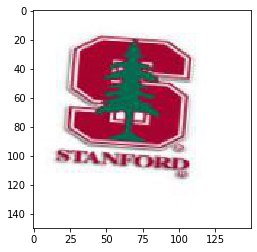

[[1.2686263e-29 0.0000000e+00 2.3096127e-34 1.0000000e+00 2.2523339e-28
  9.3558740e-29]]
STANFORD!!!!!!!!
The winner got a score of 1.0


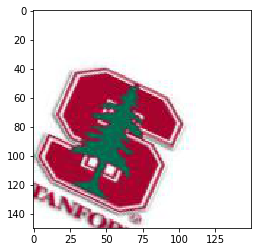

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.8139643e-33
  2.6406089e-35]]
STANFORD!!!!!!!!
The winner got a score of 1.0


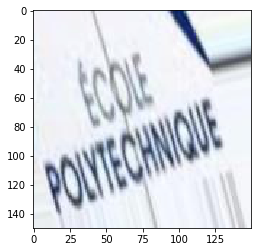

[[4.8510899e-04 8.1614608e-06 9.9944121e-01 2.6505697e-05 9.7461043e-06
  2.9328137e-05]]
X !!!!!!!!!!!
The winner got a score of 0.9994412


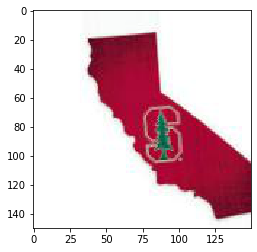

[[4.3692789e-15 2.3087307e-20 1.0540710e-19 1.0000000e+00 1.8987855e-11
  7.0724488e-16]]
STANFORD!!!!!!!!
The winner got a score of 1.0


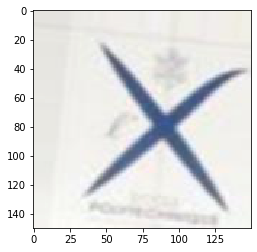

[[3.4972716e-03 1.5655083e-04 9.9388003e-01 1.8477202e-03 3.1066436e-04
  3.0786337e-04]]
X !!!!!!!!!!!
The winner got a score of 0.99388003


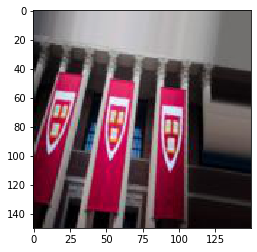

[[3.7468705e-02 1.3953031e-04 1.3450908e-05 3.5248322e-03 1.9468932e-04
  9.5865881e-01]]
HARVARD ITCH!!!!!!!!
The winner got a score of 0.9586588


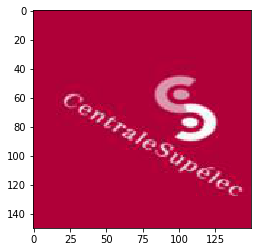

[[4.8547975e-07 3.0865209e-07 2.3514468e-09 1.4413621e-06 9.9999774e-01
  1.0653307e-08]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.99999774


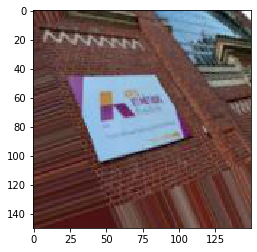

[[3.5529049e-06 9.9995494e-01 1.1042280e-06 3.0273625e-07 3.9630246e-05
  4.4000086e-07]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.99995494


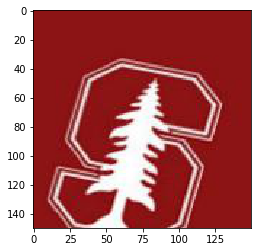

[[5.6489199e-15 6.4586644e-20 8.5334343e-18 1.0000000e+00 6.8596984e-14
  5.1131174e-15]]
STANFORD!!!!!!!!
The winner got a score of 1.0


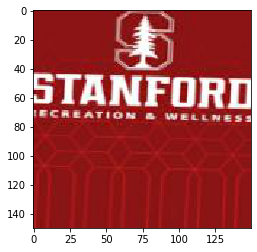

[[9.1596936e-16 4.1858510e-21 9.5034739e-19 1.0000000e+00 6.9381460e-15
  1.8611885e-16]]
STANFORD!!!!!!!!
The winner got a score of 1.0


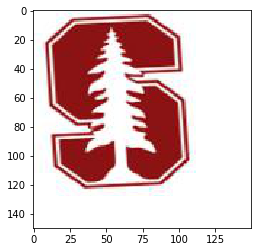

[[2.3831820e-08 2.9757885e-12 4.8617207e-11 1.0000000e+00 1.0589475e-08
  7.9721305e-09]]
STANFORD!!!!!!!!
The winner got a score of 1.0


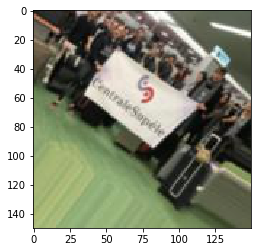

[[5.1066877e-07 1.6134037e-06 2.5348486e-08 5.0476287e-06 9.9999273e-01
  9.2531337e-08]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9999927


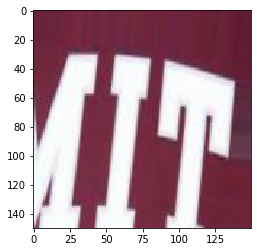

[[9.9989212e-01 1.6814842e-06 2.8444433e-07 5.2087071e-05 2.3979768e-05
  2.9923644e-05]]
MIT !!!!!!!!!!
The winner got a score of 0.9998921


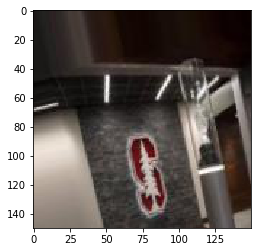

[[0.01568175 0.00578271 0.00125678 0.00316312 0.9663512  0.00776446]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9663512


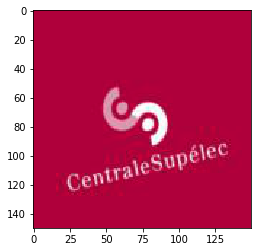

[[4.2993025e-07 2.0141532e-07 1.9095840e-09 1.8358576e-06 9.9999750e-01
  7.1782567e-09]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9999975


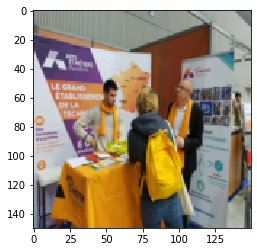

[[6.0069714e-12 1.0000000e+00 5.6748495e-11 4.7047994e-13 8.3821866e-10
  3.2383447e-11]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


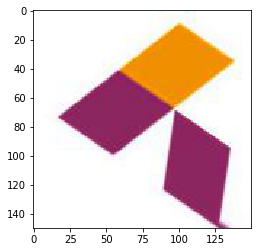

[[3.7834512e-27 1.0000000e+00 7.8254714e-31 1.3395203e-32 2.3300241e-30
  3.9632926e-30]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


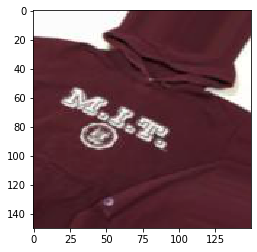

[[9.9945813e-01 1.8648843e-04 1.7000631e-05 1.7225579e-04 1.0488524e-04
  6.1258768e-05]]
MIT !!!!!!!!!!
The winner got a score of 0.99945813


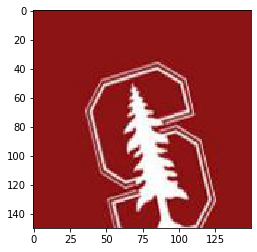

[[1.8643038e-13 7.4880467e-18 2.6533776e-16 1.0000000e+00 1.2097342e-12
  4.5194466e-13]]
STANFORD!!!!!!!!
The winner got a score of 1.0


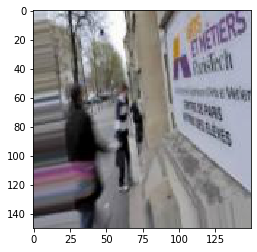

[[3.5058041e-04 9.9955398e-01 3.8459173e-05 1.5751191e-05 1.3388876e-05
  2.7837992e-05]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.999554


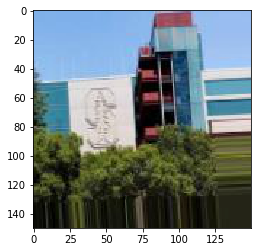

[[1.6655962e-07 1.2076353e-09 8.0831333e-09 9.9996328e-01 3.6303547e-05
  1.9039491e-07]]
STANFORD!!!!!!!!
The winner got a score of 0.9999633


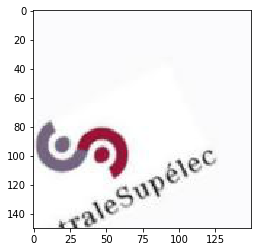

[[0.01842267 0.00392682 0.00614    0.00514174 0.01455111 0.9518177 ]]
HARVARD ITCH!!!!!!!!
The winner got a score of 0.9518177


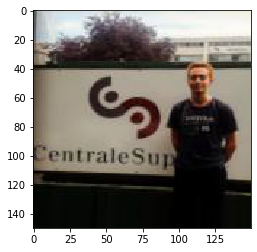

[[7.9026663e-10 6.7312499e-08 3.0649854e-11 4.8208484e-08 9.9999988e-01
  1.0616508e-09]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9999999


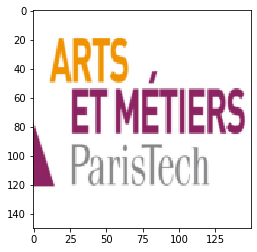

[[1.8321840e-19 1.0000000e+00 1.7762038e-22 6.1763502e-24 1.6422751e-22
  3.2642978e-22]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


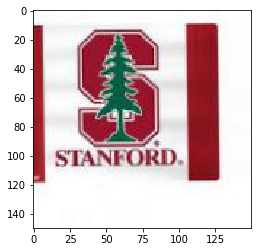

[[1.3871651e-24 2.6545493e-33 5.7739808e-28 1.0000000e+00 5.0858765e-25
  8.9847931e-23]]
STANFORD!!!!!!!!
The winner got a score of 1.0


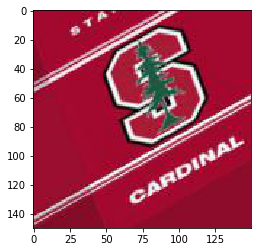

[[2.2270840e-12 4.7898939e-17 2.4868064e-15 1.0000000e+00 9.1423848e-11
  2.0268734e-13]]
STANFORD!!!!!!!!
The winner got a score of 1.0


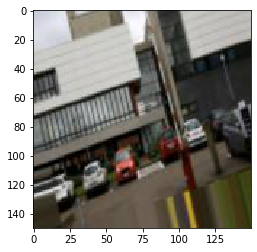

[[1.13050955e-05 9.99978900e-01 2.65724475e-06 1.08449501e-06
  5.00805891e-06 1.12607142e-06]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9999789


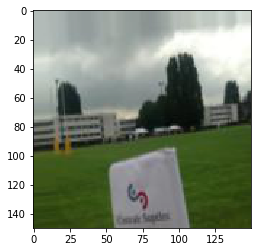

[[7.6545348e-08 8.7521721e-06 6.6433259e-08 4.8020098e-04 9.9950910e-01
  1.8059147e-06]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9995091


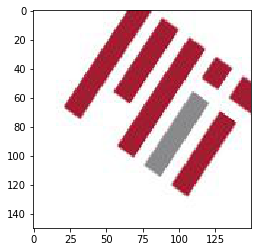

[[1.5213363e-06 1.3135829e-08 3.6660268e-08 9.9998879e-01 2.3967968e-06
  7.3305405e-06]]
STANFORD!!!!!!!!
The winner got a score of 0.9999888


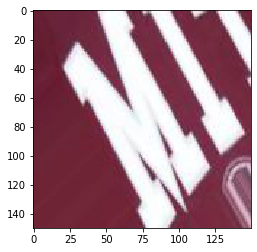

[[9.5791620e-01 9.9851080e-05 2.8576851e-06 1.8361275e-04 4.1761525e-02
  3.5965353e-05]]
MIT !!!!!!!!!!
The winner got a score of 0.9579162


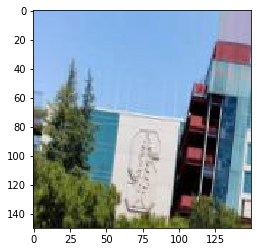

[[0.00192222 0.00891232 0.00211199 0.10668858 0.77237636 0.10798857]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.77237636


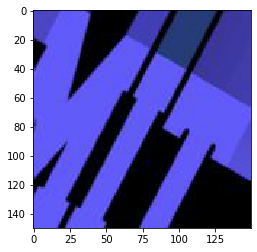

[[1.0000000e+00 0.0000000e+00 3.8941630e-36 2.8778923e-34 1.0713351e-36
  2.6431204e-26]]
MIT !!!!!!!!!!
The winner got a score of 1.0


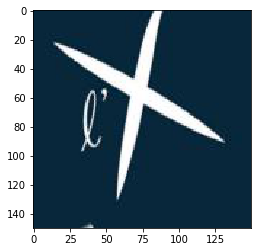

[[2.6326687e-16 1.7302991e-22 1.0000000e+00 2.7475502e-19 7.1838875e-21
  9.8685902e-21]]
X !!!!!!!!!!!
The winner got a score of 1.0


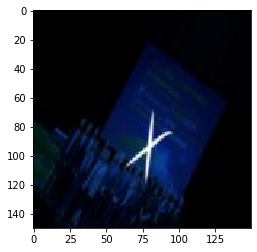

[[2.2464841e-11 7.7348624e-16 1.0000000e+00 3.0969961e-14 4.2609552e-15
  1.5707360e-14]]
X !!!!!!!!!!!
The winner got a score of 1.0


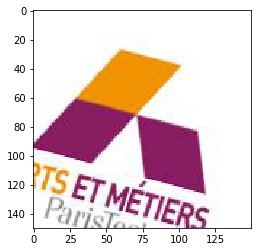

[[0. 1. 0. 0. 0. 0.]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


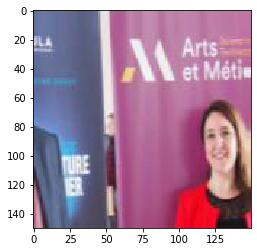

[[4.7938064e-13 1.0000000e+00 2.2888319e-14 2.0441323e-15 1.9284826e-17
  3.6029814e-14]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


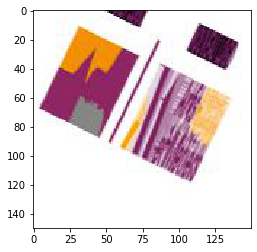

[[4.3809637e-29 1.0000000e+00 1.2578391e-33 2.5143757e-36 7.0560696e-37
  1.2797600e-32]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


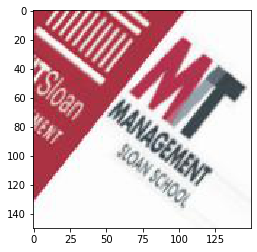

[[9.0250589e-02 3.5694975e-02 6.6474441e-04 3.5750337e-03 8.6930013e-01
  5.1456579e-04]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.8693001


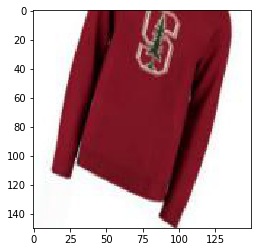

[[1.4451304e-06 4.5460378e-09 3.7636561e-08 9.9999750e-01 9.1990006e-07
  9.3108049e-08]]
STANFORD!!!!!!!!
The winner got a score of 0.9999975


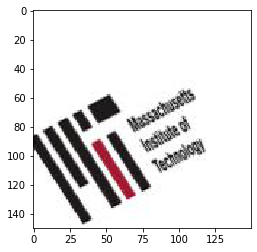

[[9.8060948e-01 3.3897275e-06 1.7334918e-05 6.3222455e-05 4.6892383e-05
  1.9259753e-02]]
MIT !!!!!!!!!!
The winner got a score of 0.9806095


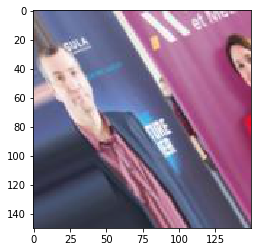

[[2.3348541e-04 9.9949038e-01 1.1117766e-04 5.0450282e-05 1.6837454e-05
  9.7692013e-05]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9994904


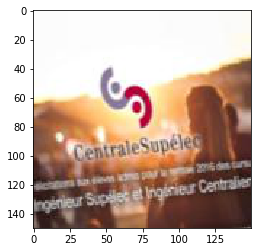

[[1.8050772e-14 2.6684172e-11 3.1382499e-15 4.1082726e-10 1.0000000e+00
  4.0164046e-14]]
CentraleSupélec!!!!!!!!
The winner got a score of 1.0


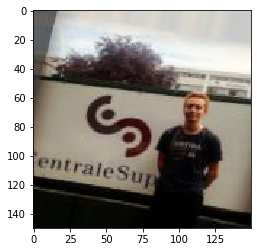

[[2.63157204e-07 1.13164815e-05 2.91418374e-08 3.11940153e-06
  9.99985099e-01 1.27406054e-07]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9999851


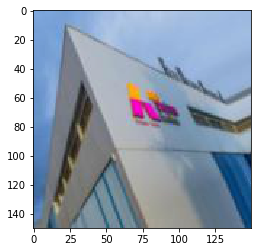

[[2.5354387e-09 7.3369008e-01 9.6786268e-10 5.6163252e-09 2.6630995e-01
  2.3538135e-10]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.7336901


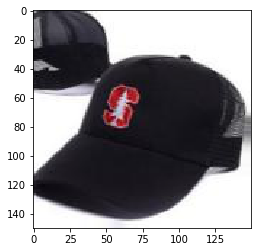

[[1.7119410e-07 9.9791272e-11 1.6606685e-10 9.9998891e-01 1.0981591e-05
  1.9687274e-08]]
STANFORD!!!!!!!!
The winner got a score of 0.9999889


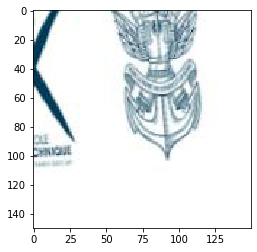

[[8.67096503e-07 7.77600206e-08 9.99998093e-01 7.31712475e-07
  1.20480735e-07 1.10151824e-07]]
X !!!!!!!!!!!
The winner got a score of 0.9999981


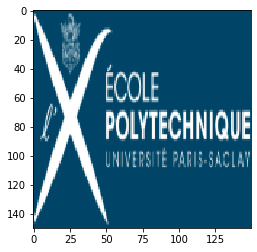

[[5.1652448e-30 0.0000000e+00 1.0000000e+00 4.6924420e-35 2.7811621e-38
  8.9649700e-38]]
X !!!!!!!!!!!
The winner got a score of 1.0


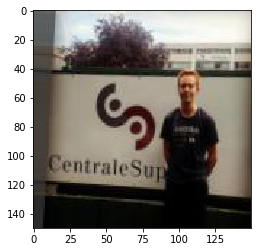

[[7.2432131e-09 3.0703148e-07 2.7667663e-10 2.4060918e-07 9.9999940e-01
  4.7360480e-09]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9999994


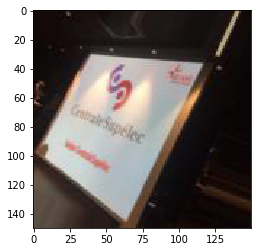

[[8.3523535e-11 1.1500226e-08 5.4325212e-12 5.7216791e-08 9.9999988e-01
  7.1647660e-11]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9999999


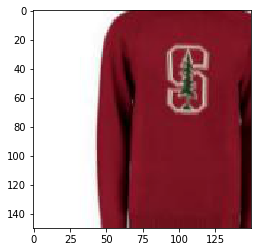

[[6.73362320e-06 7.76117375e-08 4.66228528e-07 9.99950886e-01
  1.29007885e-05 2.89734271e-05]]
STANFORD!!!!!!!!
The winner got a score of 0.9999509


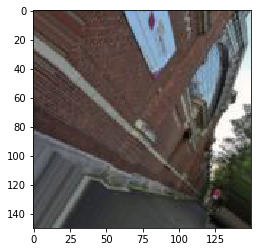

[[1.1943648e-04 9.9982208e-01 2.6965745e-05 1.0703496e-05 6.8021350e-06
  1.4052169e-05]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9998221


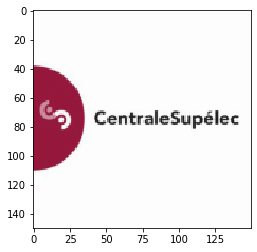

[[4.7049209e-10 2.4815205e-07 5.9600691e-10 1.9365849e-08 9.9999952e-01
  2.3496288e-07]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9999995


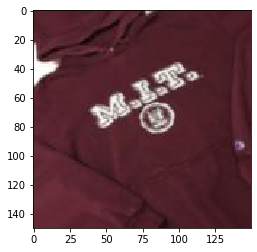

[[9.9961925e-01 4.9570841e-05 9.3405479e-06 1.5757968e-04 1.4645144e-04
  1.7901257e-05]]
MIT !!!!!!!!!!
The winner got a score of 0.99961925


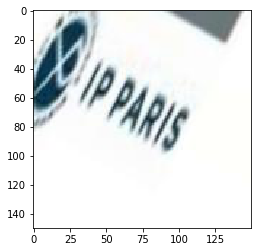

[[1.3684304e-05 1.3673866e-07 9.9998248e-01 1.7203251e-06 1.2438074e-06
  8.4308761e-07]]
X !!!!!!!!!!!
The winner got a score of 0.9999825


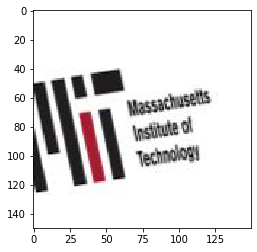

[[9.8652798e-01 1.9997508e-07 3.4427983e-06 5.1386782e-05 5.9566773e-06
  1.3411015e-02]]
MIT !!!!!!!!!!
The winner got a score of 0.986528


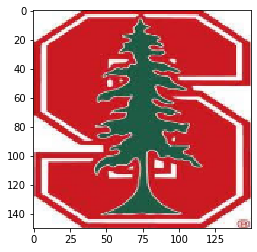

[[0. 0. 0. 1. 0. 0.]]
STANFORD!!!!!!!!
The winner got a score of 1.0


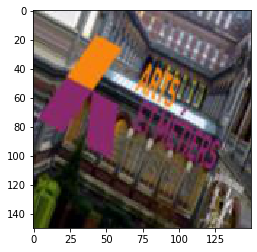

[[1.7609695e-30 1.0000000e+00 5.4460042e-36 1.8422934e-38 0.0000000e+00
  4.5755308e-35]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


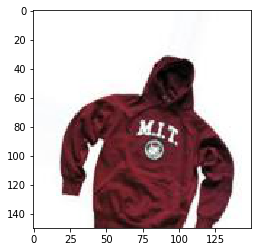

[[9.98977780e-01 1.00221005e-05 4.79974551e-06 3.19207669e-04
  6.65302970e-04 2.29297730e-05]]
MIT !!!!!!!!!!
The winner got a score of 0.9989778


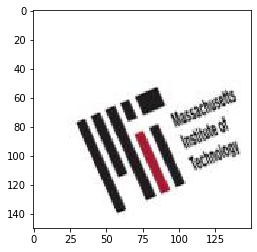

[[9.9999869e-01 4.0388795e-09 2.6351712e-09 3.0947341e-08 7.0571576e-07
  6.3417303e-07]]
MIT !!!!!!!!!!
The winner got a score of 0.9999987


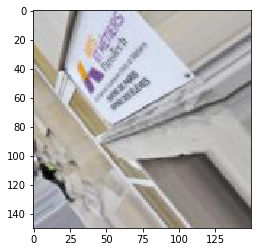

[[1.1606215e-03 9.9690288e-01 1.5105344e-03 1.1279574e-04 1.4629212e-04
  1.6688103e-04]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9969029


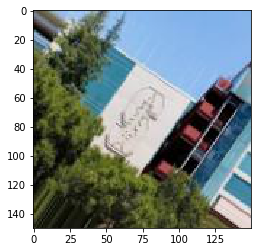

[[0.2539279  0.00317077 0.00148233 0.06852234 0.6717589  0.00113775]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.6717589


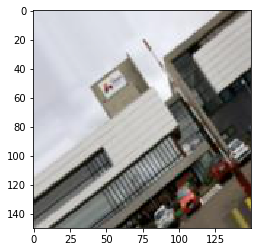

[[1.6808201e-05 9.9990380e-01 3.1635661e-06 3.9485453e-06 7.1694572e-05
  6.4293266e-07]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9999038


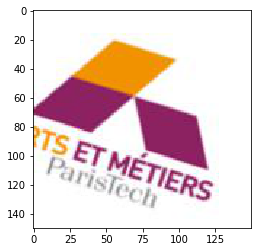

[[0. 1. 0. 0. 0. 0.]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


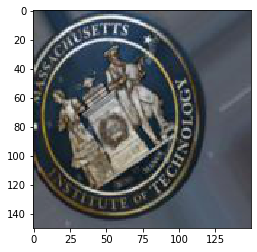

[[9.9462837e-01 3.1255683e-04 1.2908565e-03 7.6890772e-04 2.6776339e-03
  3.2172157e-04]]
MIT !!!!!!!!!!
The winner got a score of 0.99462837


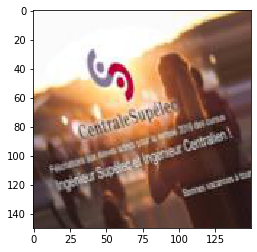

[[2.3016935e-07 5.5055576e-04 9.2575533e-08 6.6706625e-06 9.9943656e-01
  5.8107471e-06]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.99943656


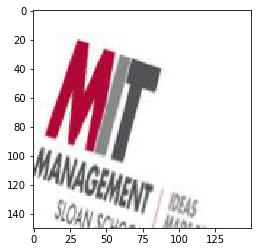

[[9.9997187e-01 2.5646730e-06 1.0440599e-06 4.6376672e-06 8.6581986e-06
  1.1130385e-05]]
MIT !!!!!!!!!!
The winner got a score of 0.99997187


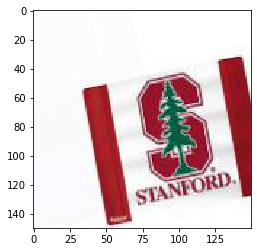

[[4.4109940e-23 4.8139868e-30 3.0822653e-28 1.0000000e+00 2.9687737e-17
  6.4897731e-23]]
STANFORD!!!!!!!!
The winner got a score of 1.0


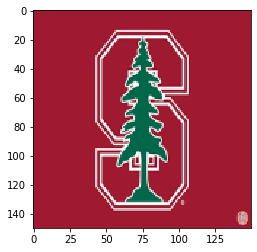

[[0. 0. 0. 1. 0. 0.]]
STANFORD!!!!!!!!
The winner got a score of 1.0


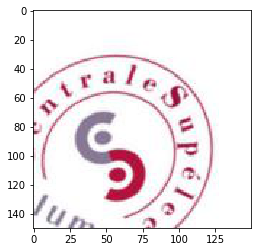

[[2.6938582e-03 3.5550676e-02 4.6722525e-05 1.1112743e-04 9.3792230e-01
  2.3675319e-02]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9379223


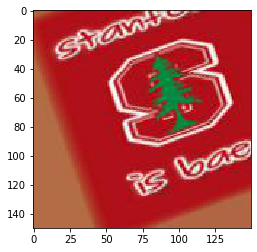

[[2.2981127e-38 0.0000000e+00 0.0000000e+00 1.0000000e+00 6.5858812e-33
  0.0000000e+00]]
STANFORD!!!!!!!!
The winner got a score of 1.0


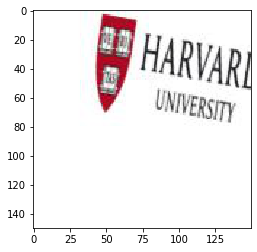

[[0.21546833 0.00089803 0.00388906 0.26949164 0.00369068 0.5065623 ]]
HARVARD ITCH!!!!!!!!
The winner got a score of 0.5065623


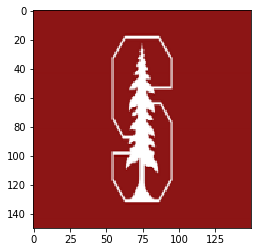

[[1.37109403e-15 1.06477605e-20 1.10629379e-18 1.00000000e+00
  3.16225588e-14 6.35301710e-16]]
STANFORD!!!!!!!!
The winner got a score of 1.0


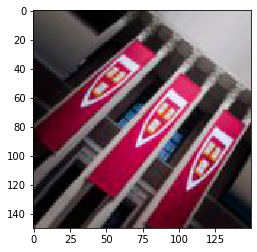

[[4.0753952e-05 5.3147854e-05 5.1966168e-07 1.2804224e-03 1.7357503e-05
  9.9860781e-01]]
HARVARD ITCH!!!!!!!!
The winner got a score of 0.9986078


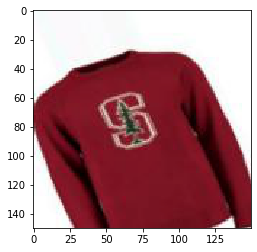

[[2.1226939e-03 1.4655082e-04 1.4251847e-04 9.9438161e-01 2.7272061e-03
  4.7932341e-04]]
STANFORD!!!!!!!!
The winner got a score of 0.9943816


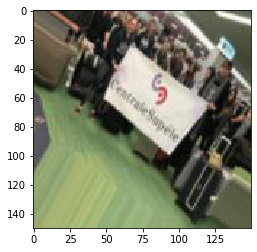

[[2.75865041e-05 5.90606169e-06 2.40628452e-07 1.45678905e-05
  9.99950767e-01 9.39842437e-07]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.99995077


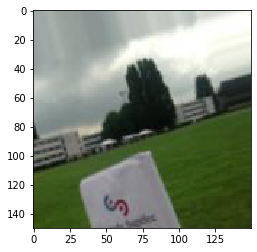

[[6.5456734e-06 1.8502650e-04 4.0076025e-06 9.7527795e-02 9.0226340e-01
  1.3185388e-05]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9022634


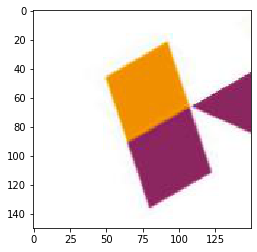

[[6.5197747e-30 1.0000000e+00 3.1220539e-33 1.3359308e-35 1.1732609e-36
  2.7573597e-32]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


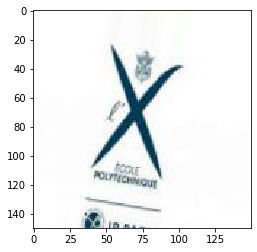

[[3.7471458e-13 3.3445993e-17 1.0000000e+00 4.4731512e-14 2.2979468e-15
  1.3668327e-15]]
X !!!!!!!!!!!
The winner got a score of 1.0


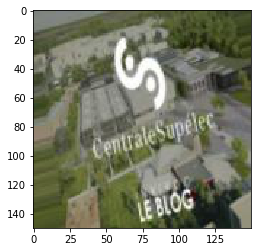

[[1.6692910e-06 1.1897521e-05 4.8081429e-06 3.5121462e-05 9.9994421e-01
  2.2490397e-06]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9999442


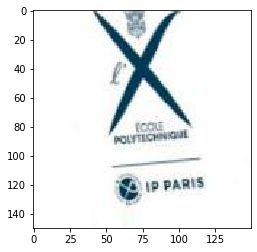

[[1.2581639e-13 7.5653596e-20 1.0000000e+00 5.7463926e-17 1.3947804e-15
  1.2080018e-17]]
X !!!!!!!!!!!
The winner got a score of 1.0


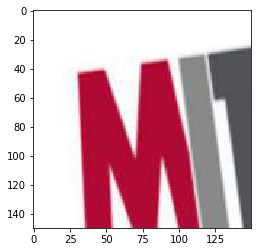

[[8.8050193e-01 1.4148273e-04 1.4870228e-04 3.0411176e-02 5.3420931e-02
  3.5375677e-02]]
MIT !!!!!!!!!!
The winner got a score of 0.8805019


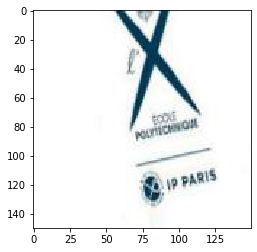

[[1.2524727e-09 1.7280700e-14 1.0000000e+00 6.4169996e-13 3.8211012e-10
  8.0955099e-13]]
X !!!!!!!!!!!
The winner got a score of 1.0


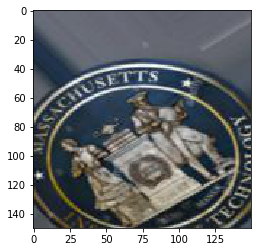

[[0.3116027  0.04291959 0.03589143 0.06636535 0.53450423 0.00871675]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.53450423


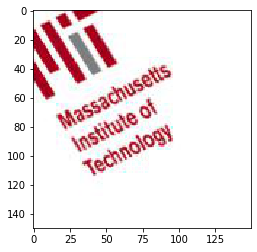

[[9.9739516e-01 4.3489847e-05 1.5428690e-05 6.5604749e-04 1.0700247e-03
  8.1976491e-04]]
MIT !!!!!!!!!!
The winner got a score of 0.99739516


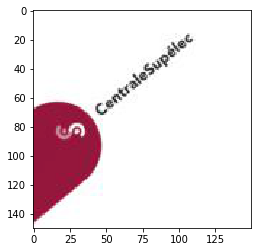

[[4.2998313e-04 1.6554839e-03 8.5083135e-05 3.8622384e-04 9.9441731e-01
  3.0259339e-03]]
CentraleSupélec!!!!!!!!
The winner got a score of 0.9944173


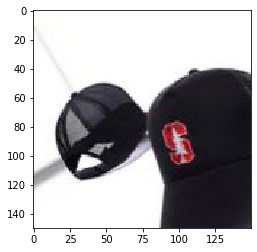

[[8.0915087e-01 7.9731218e-04 1.1671468e-04 2.1964144e-03 1.8722987e-01
  5.0875958e-04]]
MIT !!!!!!!!!!
The winner got a score of 0.8091509


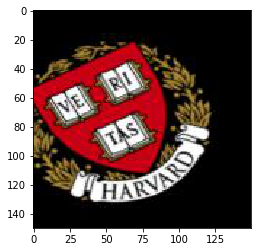

[[2.1939178e-14 3.3530431e-17 1.4083899e-19 8.3968197e-12 3.1680906e-16
  1.0000000e+00]]
HARVARD ITCH!!!!!!!!
The winner got a score of 1.0


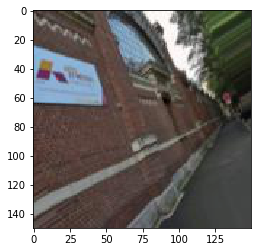

[[2.1239575e-03 9.9541438e-01 1.1414924e-03 4.2166444e-04 5.2407669e-04
  3.7439057e-04]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9954144


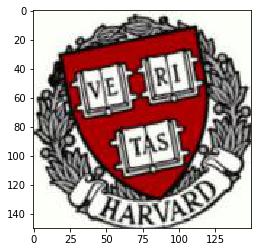

[[1.3872539e-03 2.6252119e-05 4.7689668e-06 1.6376857e-02 2.1106645e-05
  9.8218381e-01]]
HARVARD ITCH!!!!!!!!
The winner got a score of 0.9821838


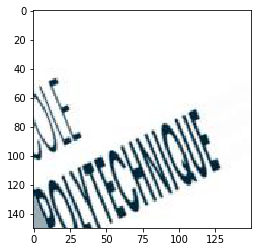

[[6.07360221e-07 7.49301565e-10 9.99999404e-01 1.58048807e-09
  2.05031858e-09 1.26047945e-08]]
X !!!!!!!!!!!
The winner got a score of 0.9999994


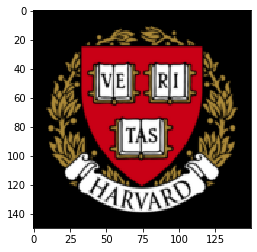

[[3.8772301e-12 3.8167915e-12 1.0823311e-14 2.6787100e-07 5.7307210e-12
  9.9999976e-01]]
HARVARD ITCH!!!!!!!!
The winner got a score of 0.99999976


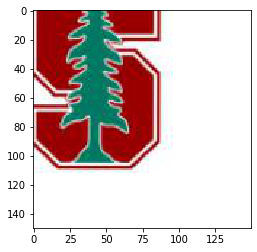

[[2.7647661e-38 0.0000000e+00 1.0847921e-34 1.0000000e+00 3.7571465e-34
  3.5765234e-30]]
STANFORD!!!!!!!!
The winner got a score of 1.0


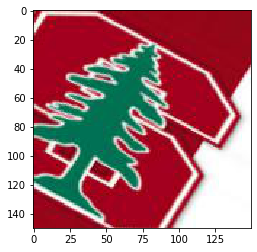

[[5.5494583e-28 4.4704445e-34 8.7355554e-09 1.0000000e+00 6.6420215e-32
  9.4670656e-28]]
STANFORD!!!!!!!!
The winner got a score of 1.0


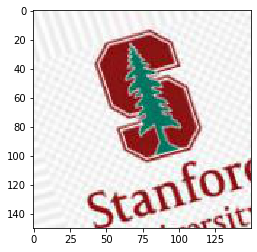

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.7108919e-36
  0.0000000e+00]]
STANFORD!!!!!!!!
The winner got a score of 1.0


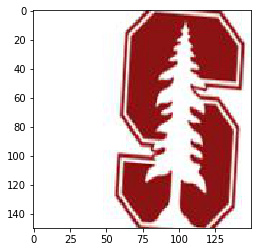

[[3.0810512e-15 2.0344121e-19 2.6678873e-19 1.0000000e+00 6.6962942e-11
  7.7445103e-14]]
STANFORD!!!!!!!!
The winner got a score of 1.0


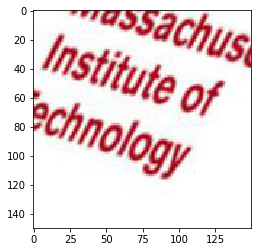

[[9.9766219e-01 1.4888884e-06 5.5006272e-08 2.6816471e-05 2.3092192e-03
  2.5503257e-07]]
MIT !!!!!!!!!!
The winner got a score of 0.9976622


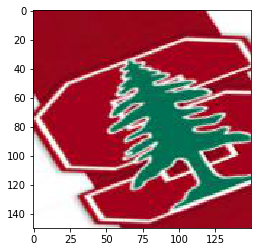

[[0. 0. 0. 1. 0. 0.]]
STANFORD!!!!!!!!
The winner got a score of 1.0


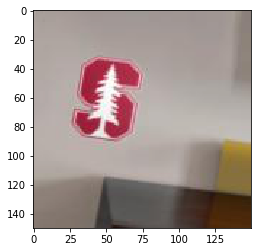

[[1.3887799e-05 2.8885563e-07 1.8578603e-06 9.9991024e-01 2.4966661e-05
  4.8697068e-05]]
STANFORD!!!!!!!!
The winner got a score of 0.99991024


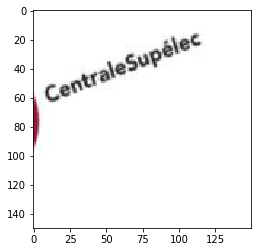

[[0.86225915 0.00113193 0.07244637 0.00736696 0.05296766 0.00382798]]
MIT !!!!!!!!!!
The winner got a score of 0.86225915


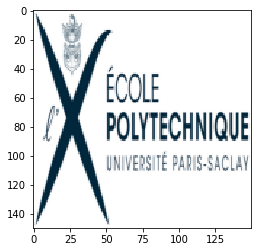

[[1.0007318e-13 1.1752438e-16 1.0000000e+00 3.2152951e-15 1.3217194e-17
  1.0184725e-13]]
X !!!!!!!!!!!
The winner got a score of 1.0


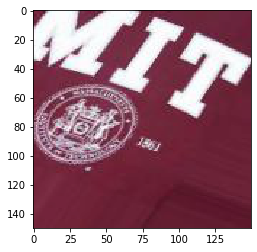

[[9.9997866e-01 3.2929657e-07 7.7464811e-08 1.3906245e-05 4.8009038e-06
  2.0890234e-06]]
MIT !!!!!!!!!!
The winner got a score of 0.99997866


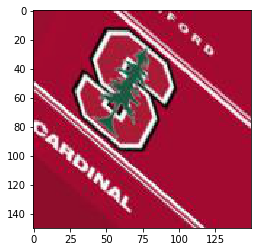

[[4.4212989e-14 2.3798404e-18 2.5620671e-16 1.0000000e+00 3.8351384e-12
  2.3097255e-13]]
STANFORD!!!!!!!!
The winner got a score of 1.0


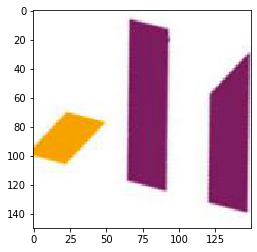

[[8.0628847e-25 1.0000000e+00 3.8635351e-28 1.1243437e-29 2.4122361e-30
  7.3500434e-28]]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


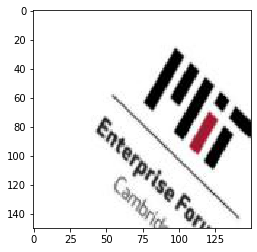

[[9.6921462e-01 7.6850938e-06 7.1782160e-06 6.3954583e-05 3.0644493e-02
  6.1954881e-05]]
MIT !!!!!!!!!!
The winner got a score of 0.9692146


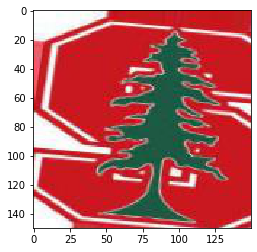

[[0. 0. 0. 1. 0. 0.]]
STANFORD!!!!!!!!
The winner got a score of 1.0


KeyboardInterrupt: 

In [141]:
#X_test
for x in X_test:
    plt.imshow(x)
    plt.show()
    result=model.predict(x.reshape(-1,size,size,3))
    winner=np.max(result)
    for ele in result:
        print(result)
        if ele[0]>=winner:
            print("MIT !!!!!!!!!!")  #MIT=1,0,0,0,0,0
        if ele[1]>=winner:
            print("BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!")  #AM=0,1,0,0,0,0 
        if ele[2]>=winner:           
            print("X !!!!!!!!!!!")   #X=0,0,1,0,0,0
        if ele[3]>=winner:
            print("STANFORD!!!!!!!!")#STAN=0,0,0,1,0,0
        if ele[4]>=winner:
            print("CentraleSupélec!!!!!!")#CS=0,0,0,0,1,0
        if ele[5]>=winner:
            print("HARVARD ITCH!!!!!!!!")#HARV=0,0,0,0,0,1
    print("The winner got a score of "+ str(np.max(result)))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

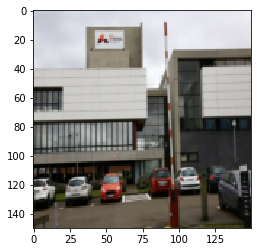

[5.0870801e-07 9.9999952e-01 2.8912988e-08 1.8250503e-08 4.7581867e-09
 2.6481644e-08]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9999995


<IPython.core.display.Javascript object>

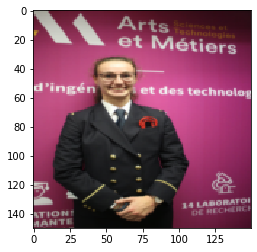

[1.4373885e-10 1.0000000e+00 3.0266772e-12 4.2466475e-13 5.5150800e-13
 4.2537350e-12]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


<IPython.core.display.Javascript object>

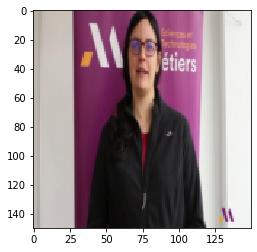

[3.9082482e-10 1.0000000e+00 4.2055248e-12 5.4966920e-13 2.6573385e-12
 2.4735361e-12]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


<IPython.core.display.Javascript object>

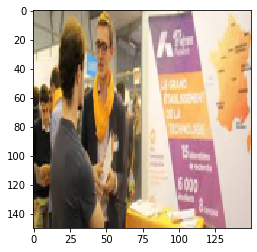

[8.3171496e-13 1.0000000e+00 1.0957121e-14 6.1224457e-16 4.3978730e-15
 4.5289513e-15]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


<IPython.core.display.Javascript object>

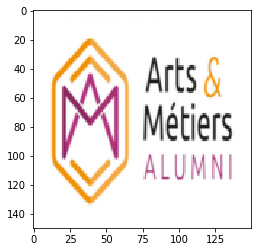

[1.6889913e-08 1.0000000e+00 8.2092178e-10 3.1159197e-11 2.6098781e-10
 2.1761237e-09]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


<IPython.core.display.Javascript object>

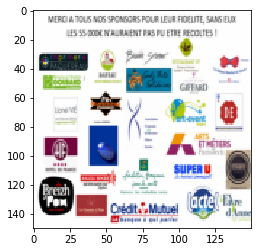

[1.0435211e-04 6.2387701e-02 7.5833780e-01 1.9981051e-05 1.7907669e-01
 7.3517440e-05]
X !!!!!!!!!!!
The winner got a score of 0.7583378


<IPython.core.display.Javascript object>

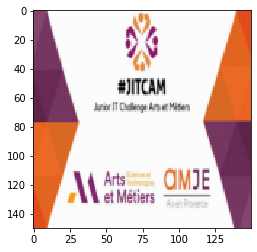

[3.4691253e-05 1.9990893e-03 9.9795073e-01 1.4266749e-06 1.3143227e-05
 9.4557612e-07]
X !!!!!!!!!!!
The winner got a score of 0.99795073


<IPython.core.display.Javascript object>

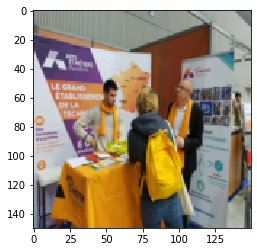

[6.0069714e-12 1.0000000e+00 5.6748495e-11 4.7047994e-13 8.3821866e-10
 3.2383447e-11]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 1.0


<IPython.core.display.Javascript object>

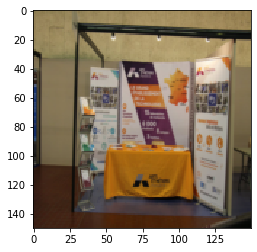

[2.5377830e-07 9.9714112e-01 9.6456904e-05 2.1412299e-07 2.7588378e-03
 3.2537755e-06]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.9971411


<IPython.core.display.Javascript object>

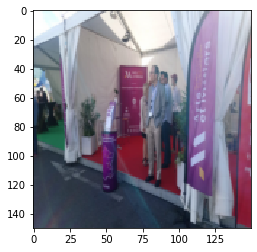

[0.20408046 0.6073398  0.05554638 0.03697679 0.0663338  0.02972271]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.6073398


<IPython.core.display.Javascript object>

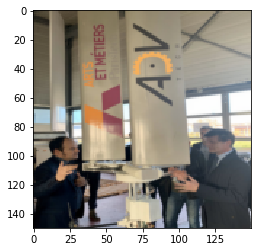

[7.1602290e-06 9.9992275e-01 3.5567537e-06 7.7360710e-07 6.5280263e-05
 4.4434009e-07]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.99992275


<IPython.core.display.Javascript object>

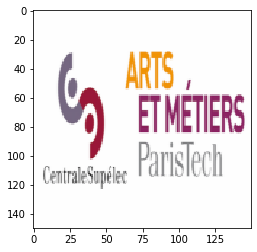

[7.1690613e-07 3.5947379e-02 7.3342257e-08 3.5635534e-07 9.6405077e-01
 6.9520121e-07]
CentraleSupélec!!!!!!!!
The winner got a score of 0.96405077


<IPython.core.display.Javascript object>

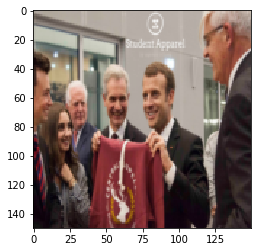

[3.8023856e-03 9.4915485e-01 1.3743946e-03 9.9706103e-04 4.4094045e-02
 5.7727017e-04]
BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!
The winner got a score of 0.94915485


<IPython.core.display.Javascript object>

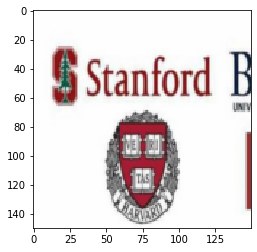

[1.0061920e-02 4.0737312e-05 1.2565692e-05 4.5242187e-04 2.5502377e-04
 9.8917741e-01]
HARVARD ITCH!!!!!!!!
The winner got a score of 0.9891774


<IPython.core.display.Javascript object>

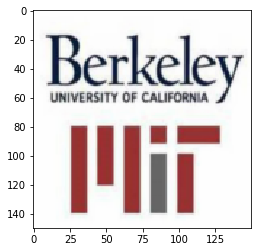

[7.1023476e-01 6.8294876e-06 5.1406951e-06 1.7092115e-04 5.1557381e-06
 2.8957713e-01]
MIT !!!!!!!!!!
The winner got a score of 0.71023476


<IPython.core.display.Javascript object>

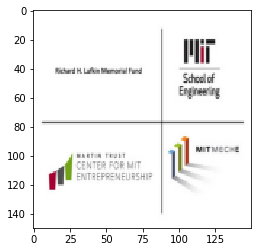

[0.6213621  0.10761549 0.25576454 0.00607286 0.00675373 0.00243123]
MIT !!!!!!!!!!
The winner got a score of 0.6213621


<IPython.core.display.Javascript object>

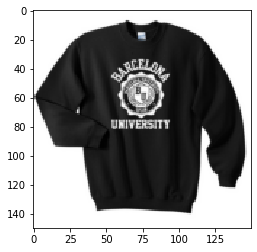

[9.9996293e-01 2.6162323e-07 4.0085308e-08 8.8115297e-07 2.7046170e-05
 8.8917459e-06]
MIT !!!!!!!!!!
The winner got a score of 0.9999629


In [143]:
#Intriguing pictures
path="./data/Testing intriguing pics"
for x in os.listdir(path):
    imgarray = imageio.imread(os.path.join(path,x), pilmode='RGB')
    imgresized = transform.resize(imgarray, (size,size), mode='symmetric')
    plt.imshow(imgresized, cmap="gray")
    plt.show()
    result=model.predict(imgresized.reshape(-1,size,size,3))
    winner=np.max(result)
    ele=result[0]
    print(ele)
    if ele[0]>=winner:
        print("MIT !!!!!!!!!!")
    if ele[1]>=winner:
        print("BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!")
    if ele[2]>=winner:
        print("X !!!!!!!!!!!")
    if ele[3]>=winner:
        print("STANFORD!!!!!!!!")
    if ele[4]>=winner:
        print("CentraleSupélec!!!!!!!!")
    if ele[5]>=winner:
        print("HARVARD ITCH!!!!!!!!")
    print("The winner got a score of "+ str(np.max(result)))

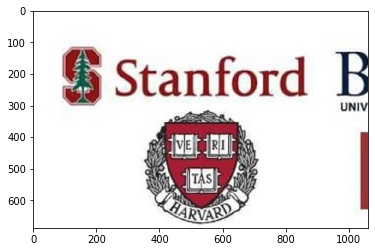

[[1.0061920e-02 4.0737312e-05 1.2565692e-05 4.5242187e-04 2.5502377e-04
  9.8917741e-01]]
HARVARD ITCH!!!!!!!!
The winner got a score of 0.9891774


In [55]:
#Specify the path to the picture
path='./data/Testing intriguing pics/harvardstanford.jpg'
imgarray = imageio.imread(path, pilmode='RGB')
imgresized = transform.resize(imgarray, (size,size), mode='symmetric')
plt.imshow(imgarray, cmap="gray")
plt.show()
result=model.predict(imgresized.reshape(-1,size,size,3))
winner=np.max(result)
for ele in result:
    print(result)
    if ele[0]>=winner:
        print("MIT !!!!!!!!!!")
    if ele[1]>=winner:
        print("BESSSSSST SCHOOOOOOL IN THA GLOOBE HOOMIIE !!!!")
    if ele[2]>=winner:
        print("X !!!!!!!!!!!")
    if ele[3]>=winner:
        print("STANFORD!!!!!!!!")
    if ele[4]>=winner:
        print("CentraleSupélec!!!!!!!!")
    if ele[5]>=winner:
        print("HARVARD ITCH!!!!!!!!")
print("The winner got a score of "+ str(np.max(result)))

## 8-In Case you're not familiar with tensorboard

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.figure(figsize=(5, 5))
plt.subplot(2,1,1)
plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc'], loc='lower left')
plt.subplot(2,1,2)
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'], loc='upper left')
plt.ylim([0, 1.5])
plt.tight_layout()

score = modelaug.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0]) #Test loss: 0.0296396646054
print('Test accuracy:', score[1]) #Test accuracy: 0.9904